In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import requests
import shutil
import xarray as xr

import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype import ACSTSCor
from acspype.utils.ooi import get_ooi_optaa_cal, reformat_ooi_optaa
from acspype.experimental import compute_chl_alh

## Acquire a File From CE02SHSM Deployment 9

1. First we import the dataset from Thredds using Xarray.
2. Then we reformat the dataset to be compatible with acspype using `reformat_ooi_optaa`.
    -   No ACS data are removed from the dataset, only excess variables (e.g. pressure_counts) and timestamps (e.g. port_timestamp). These are either not needed for processing or are meaningless.
    - Some variables are compressed and assigned reassigned dimensions (e.g. lat, lon, deployment) since they should be the same throughout a single file. 
    - File and variable attributes are preserved.
    - Attributes and variables are alphabetized.
3. `reformat_ooi_optaa` renames `optical_absorption` and `beam_attenuation` to `a_m_discontinuity` and `c_m_discontinuity`, respectively, since OOI does not correct for the discontinuity jump inherent in all ACS'. We can drop these because we will reprocess to that stage as part of this example anyway.
4. Since `reformat_ooi_optaa` adds the dimensions of latitude, longitude, and deployment, and we are only working with a single deployment file, we can subset by those values.

In [2]:
def download_and_load_goldcopy(url):
    filename = os.path.basename(url)
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        return ds
    else:
        with requests.get(url, stream = True) as req:
            with open(filename, 'wb') as fileobj:
                shutil.copyfileobj(req.raw, fileobj)
        if os.path.isfile(filename):
            ds = xr.open_dataset(filename)
            return ds
        else:
            return FileNotFoundError

In [3]:
http_url = "http://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSM-RID27-01-OPTAAD000-recovered_host-optaa_dj_dcl_instrument_recovered/deployment0009_CE02SHSM-RID27-01-OPTAAD000-recovered_host-optaa_dj_dcl_instrument_recovered_20190622T003023-20190723T233200.492000.nc"

ds = download_and_load_goldcopy(http_url)

In [4]:

ds = reformat_ooi_optaa(ds)

ds = ds.drop_vars(['a_m_discontinuity', 'c_m_discontinuity'], errors='ignore')  

ds = ds.sel(latitude = float(ds.latitude), longitude = float(ds.longitude), deployment = int(ds.deployment))

## Acquire the Device Factory Calibration Information and TS Correction Coefficients
The factory calibration information is available through the OOI REST API. The `get_ooi_optaa_cal` function retrieves this information and reformats it to match the format of acspype's `ACSDev` class. The `ACSTSCor` class imports coefficients that have been pre-compiled to a Python file within acspype from the original TS4.cor file that accompanies each device. These files should be the same between all ACS.
If using acspype to process ACS data, you do not need to import the TS4.cor file on your own, but that functionality exists through the `ACSTS4CorReader` class if you want to do that yourself.

In [5]:
dev = get_ooi_optaa_cal(ds)
tscor = ACSTSCor()

## Reprocess the Data

In [6]:
ds['internal_temperature'] = acsproc.compute_internal_temperature(ds['raw_internal_temperature'])
ds['external_temperature'] = acsproc.compute_external_temperature(ds['raw_external_temperature'])

In [7]:
ds['a_uncorrected'] = acsproc.compute_uncorrected(ds['a_signal'], ds['a_reference'], dev)
ds['c_uncorrected'] = acsproc.compute_uncorrected(ds['c_signal'], ds['c_reference'], dev)

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [8]:
ds['a_m_discontinuity'] = acsproc.compute_measured(ds['a_uncorrected'], 'a', ds['internal_temperature'], dev)
ds['c_m_discontinuity'] = acsproc.compute_measured(ds['c_uncorrected'], 'c', ds['internal_temperature'], dev)

In [9]:
discontinuity_index = acsproc.find_discontinuity_index(ds['a_wavelength'], ds['c_wavelength'])
ds['a_m'], ds['a_discontinuity_offset'] = acsproc.discontinuity_correction(ds.a_m_discontinuity, 'a_wavelength', discontinuity_index)
ds['c_m'], ds['c_discontinuity_offset'] = acsproc.discontinuity_correction(ds.c_m_discontinuity, 'c_wavelength', discontinuity_index)

In [10]:
ds['a_mts'] = acsproc.ts_correction(ds.a_m, 'a', ds.sea_water_temperature, ds.sea_water_practical_salinity, dev, tscor)
ds['c_mts'] = acsproc.ts_correction(ds.c_m, 'c', ds.sea_water_temperature, ds.sea_water_practical_salinity, dev, tscor)

In [11]:
ds['a_mts'] = acsproc.zero_shift(ds.a_mts)
ds['c_mts'] = acsproc.zero_shift(ds.c_mts)

In [12]:
ds['a_mts_baseline'] = acsproc.scattering_correction_baseline(ds.a_mts)

In [13]:
ds.a_mts_baseline.attrs

{'reference_wavelength': 715,
 'method': 'Baseline Scattering Correction - Method 1'}

## Flag Data

In [14]:
ds['flag_internal_temperature'] = acsqaqc.internal_temperature_test(ds['internal_temperature'], dev)
ds['flag_elapsed_time'] = acsqaqc.elapsed_time_test(ds['elapsed_time'])

In [15]:
# Add more tests here and section about removing bad data.

## Interpolate to Common Wavelengths

In [16]:
ds = acsproc.interpolate_common_wavelengths(ds)

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


## Calculate Chlorophyll-a

In [17]:
ds['chl_alh'] = compute_chl_alh(ds['a_mts_baseline'])

In [18]:
chlr = ds['chl_alh'].rolling(time = 12+1, center = True).median(skipna = True)
chlr = chlr.resample(time = '3h').mean(skipna = True)

## Quick Plot

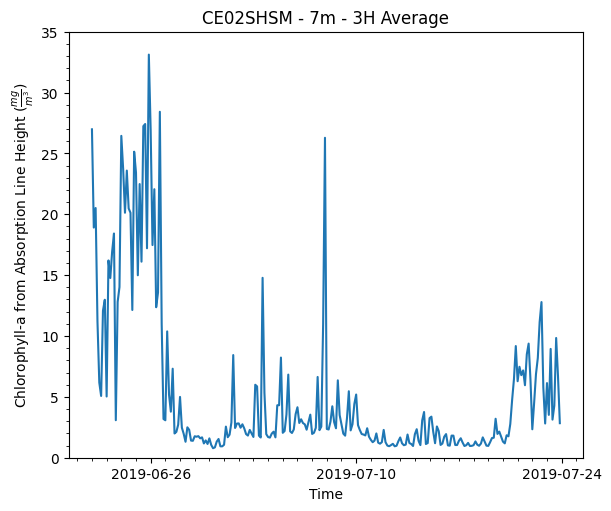

In [19]:
fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)
ax.plot(chlr.time, chlr)

ax.set_ylim(0, 35)
ax.set_xlabel('Time')
ax.set_ylabel(r'Chlorophyll-a from Absorption Line Height ($\frac{mg}{m^3}$)')
ax.set_title('CE02SHSM - 7m - 3H Average')

ax.xaxis.set_major_locator(mdates.DayLocator(interval = 14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval = 1))
ax.yaxis.set_major_locator(mticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))